### Environment Setup

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import gym

In [4]:
from gym.envs.registration import register

try:
    register(
        id='FrozenLakeNotSlippery-v0', # name given to this new environment
        entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv', # env entry point
        kwargs={'map_name': '4x4', 'is_slippery': False}, # argument passed to the env
        max_episode_steps = 100,
        reward_threshold = 0.78, # optimum = .8196
    )
except:
    print("Already registered!")

In [5]:
from IPython.display import clear_output

In [6]:
env = gym.make('FrozenLakeNotSlippery-v0') # customized version of FrozenLake
env.reset()

for step in range(15):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    time.sleep(0.3)
    clear_output(wait=True) # clearing the output in order to re render the env
    if done:
        env.reset()
    
env.close()
# all the actions doesn't matter coz it fell into the hole

  (Left)
SFFF
FHFH
FFFH
HFFG


In [7]:
observation # observation or state is at position 4, we call it observation as used in OpenAI but in AI we say state

0

### Set Initial Hyperparameter and Q-Table

In [18]:
action_size = env.action_space.n # returns no. of available actions i.e 4 - up down left and right
state_size = env.observation_space.n # returns no. of possible states in a 4x4 i.e 16
# rows--States  columns--Actions?
q_table = np.zeros([state_size, action_size])
q_table # 4 columns for actions and 16 rows for states

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [9]:
EPOCHS = 20000 # episodes - no. of times agent plays the game i.e. it has to hit done

In [10]:
ALPHA = 0.8 # learning rate - if set very low then it will take a long time for training; if set too high 
            # it may never actually converge. It needs to be set in balanced
GAMMA = 0.95 # DISCOUNT RATE recall is going to be multiplied with rewards ; gamma^2 r + gamma^3 ...
            # more gamma more rewards; less gamma less rewards

In [11]:
epsilon = 1.0 # default exploration rate
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001 # exponential decay

### Update Functions
#### The critical 3 update functions for our Q-Table learning process
####     - Epsilon-Greedy Action Selection
####     - Computation of Next Q Value
####     - Epsilon Reduction

In [12]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    # discrete_state is betwee 0 and 15
    
    random_number = np.random.random()
    
    # EXPLOITATION (choose the action that maximizes Q)
    if random_number > epsilon:
        # initially epsilon is 1.0; as we play more and more game, then epsilon will decay with a rate 0.001 and 
        # eventually random no. [0,1) will be greater than epsilon
        
        state_row = q_table[discrete_state,:] # rows are states ina Q table
        
        action = np.argmax(state_row)
        # action is 0,1,2,3 ie. the index associated with the max Q value
        
    
    # EXPLORATION (choose a random action)
    else: # happens in the beginning
        action = env.action_space.sample()
        
    return action

In [13]:
# 0,1,2,3
s_row = np.array([0,0.1,0,0]) # ROW

In [14]:
np.argmax(s_row)

1

In [15]:
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA*next_optimal_q_value - old_q_value)

In [16]:
def rduce_epsilon(epsilon,epoch):
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

In [17]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Agent Training

<IPython.core.display.Javascript object>


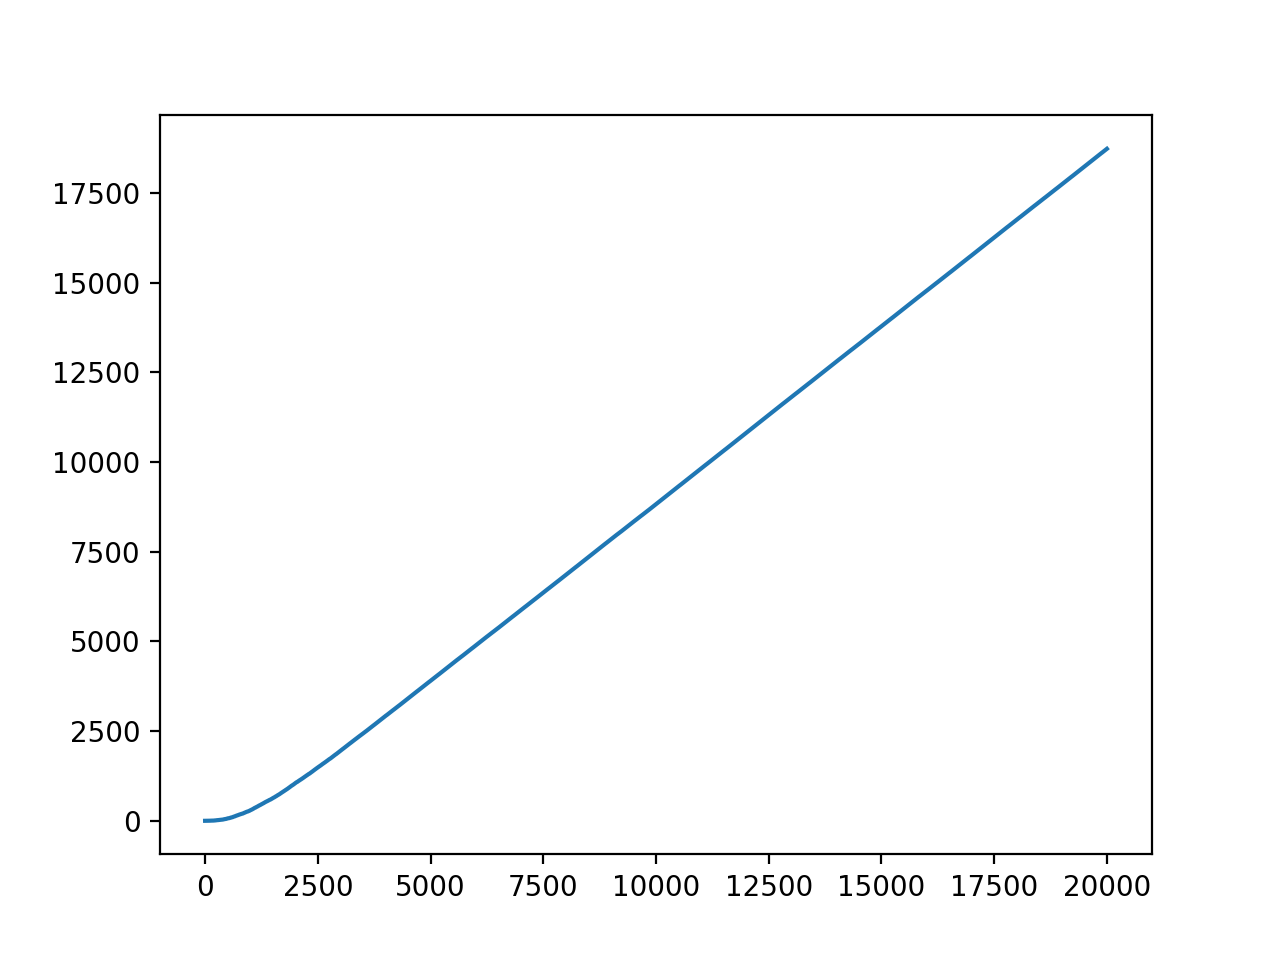

In [20]:
rewards = []
log_interval = 1000

#############################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
epoch_plot_tracker = []
total_reward_plot_tracker = []

#############################

for episode in range(EPOCHS):
    
    state = env.reset()
    done = False
    total_rewards = 0
    
    # Agent plays the game
    while not done: # not got into hole or reached the goal
        
        # take an ACTION
        action = epsilon_greedy_action_selection(epsilon, q_table, state)
        
        # state, reward.. env.step()
        new_state, reward, done, info = env.step(action)
        
        # OLD (Current) Q VALUE Q(st, at)
        old_q_value = q_table[state,action]
        
        # Get next optimal Q Value (max Q value for this state) Q(st+1, at+1)
        next_optimal_q_value = np.max(q_table[new_state,:])
        
        # Compute the next Q Value
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        
        # Update the table
        q_table[state,action] = next_q
        
        # track rewards
        total_rewards = total_rewards + reward
        
        # new state is the state
        state = new_state
        
    # Agent finished a round of the game
    episode += 1
    
    epsilon = rduce_epsilon(epsilon, episode)
    
    rewards.append(total_rewards)
    
    total_reward_plot_tracker.append(np.sum(rewards))
    epoch_plot_tracker.append(episode)
    
    #############################
    if episode % log_interval == 0:
        ax.clear()
        ax.plot(epoch_plot_tracker,total_reward_plot_tracker)
        fig.canvas.draw()
    #############################
    
env.close()
        

### Visualization and Utilization

In [77]:
q_table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.76469819, 0.77162206],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [79]:
state = env.reset()

for steps in range(100):
    env.render()
    action = np.argmax(q_table[state,:])
    state,reward,done,info = env.step(action)
    
    time.sleep(1)
    clear_output(wait=True)
    
    if done:
        break
        
env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG
